### Referencia: Statistical Uncertainties in Moment Maps of Line Emission

- Richard Teague
- Published May 2019
- [https://iopscience.iop.org/article/10.3847/2515-5172/ab2125]
- [https://ui.adsabs.harvard.edu/abs/2019RNAAS...3...74T/abstract]

In [1]:
import bettermoments as bm
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

## Lectura, selección de canales y calculo del RMS

In [2]:
# Ruta al archivo FITS
ruta_fits = '/home/jennifer/casa/M17_SW/ALMA01480118.fits'

# Cargar los datos y el eje de velocidades
data, velax = bm.load_cube(ruta_fits)
# OJO bm.load_cube no genera bien los valores de velax, toca calcularlos manualmente

In [3]:
# Abrir el archivo FITS original
with fits.open(ruta_fits) as hdul:
    header_original = hdul[0].header

# Mostrar todas las claves del header
for key in header_original.keys():
    print(f"{key}: {header_original[key]}")


SIMPLE: True
BITPIX: -32
NAXIS: 4
NAXIS1: 472
NAXIS2: 392
NAXIS3: 381
NAXIS4: 1
EXTEND: True
BSCALE: 1.0
BZERO: 0.0
BMAJ: 0.0002053843081364
BMIN: 0.0001314189721774
BPA: -71.55246581313
BTYPE: Intensity
OBJECT: M17SW
BUNIT: Jy/beam
RADESYS: ICRS
LONPOLE: 180.0
LATPOLE: -16.19584039384
PC1_1: 1.0
PC2_1: 0.0
PC3_1: 0.0
PC4_1: 0.0
PC1_2: 0.0
PC2_2: 1.0
PC3_2: 0.0
PC4_2: 0.0
PC1_3: 0.0
PC2_3: 0.0
PC3_3: 1.0
PC4_3: 0.0
PC1_4: 0.0
PC2_4: 0.0
PC3_4: 0.0
PC4_4: 1.0
CTYPE1: RA---SIN
CRVAL1: 275.1008873835
CDELT1: -2.638888888579e-05
CRPIX1: 206.0
CUNIT1: deg
CTYPE2: DEC--SIN
CRVAL2: -16.19584039384
CDELT2: 2.638888888579e-05
CRPIX2: 94.0
CUNIT2: deg
CTYPE3: FREQ
CRVAL3: 219428953435.0
CDELT3: 610511.705719
CRPIX3: 1.0
CUNIT3: Hz
CTYPE4: STOKES
CRVAL4: 1.0
CDELT4: 1.0
CRPIX4: 1.0
CUNIT4: 
PV2_1: 0.0
PV2_2: 0.0
RESTFRQ: 219560358000.0
SPECSYS: LSRK
ALTRVAL: 179422.6329954
ALTRPIX: 1.0
VELREF: 257
COMMENT: casacore non-standard usage: 4 LSD, 5 GEO, 6 SOU, 7 GAL
TELESCOP: ALMA
OBSERVER: alipnick
D

In [4]:
# Extraer parámetros del header
crval3 = header_original.get('CRVAL3')  # Frecuencia central (Hz)
cdelt3 = header_original.get('CDELT3')  # Ancho de canal en Hz
crpix3 = header_original.get('CRPIX3')  # Índice del canal de referencia

# Número de canales en el cubo
n_channels = data.shape[0]

# Generar el eje de frecuencias correctamente
velax = crval3 + (np.arange(n_channels) - (crpix3 - 1)) * cdelt3


In [5]:
# Definir los índices de los canales a usar
channel_min = 180
channel_max = 200

# Extraer solo los canales seleccionados
data_selected = data[channel_min:channel_max+1, :, :]
velax_selected = velax[channel_min:channel_max+1]

# Verificar los valores seleccionados
print(f"Min velax_selected (Hz): {np.min(velax_selected)}")
print(f"Max velax_selected (Hz): {np.max(velax_selected)}")

Min velax_selected (Hz): 219538845542.02942
Max velax_selected (Hz): 219551055776.1438


In [6]:
# Definir umbral de detección (mi caso es: 3 sigma)
snr_threshold = 3

# Calcular el RMS del ruido en canales sin señal
sigma_rms = np.std(data[:100, :, :])  # Suponiendo que los primeros 100 canales no tienen señal

# Crear la máscara: True donde la señal es significativa
mask_selected = np.where(data_selected > snr_threshold * sigma_rms, True, False)
print(f'sigma RMS estimado: {sigma_rms:.3e} unidades de los datos')

sigma RMS estimado: 2.716e-03 unidades de los datos


In [8]:
########################### APLICANDO LA MASK

# Aplicar la máscara al cubo de datos
data_masked = np.where(mask_selected, data_selected, 0)  # Poner en 0 los píxeles sin señal

## Calculo del momento 0

In [12]:
# Calcular Momento 0 (Intensidad Integrada) en los canales seleccionados
moment0, err_m0 = bm.collapse_zeroth(velax_selected, data_selected, sigma_rms)
#moment0, err_m0 = bm.collapse_zeroth(velax_selected, data_masked, sigma_rms)

In [13]:
print(f"Valor máximo en moment0: {np.max(moment0)}")
print(f"Valor mínimo en moment0: {np.min(moment0)}")

Valor máximo en moment0: 589762.2339452301
Valor mínimo en moment0: -290096.3063714035


In [14]:
print(err_m0)
np.max(err_m0)
len(err_m0)
print(f"Forma de err_m0: {err_m0.shape}")
print(f"Número total de valores en err_m0: {err_m0.size}")
print(f"Valor máximo en err_m0: {np.max(err_m0)}")
print(f"Valor mínimo en err_m0: {np.min(err_m0)}")
num_zeros = np.sum(err_m0 == 0)
print(f"Número de píxeles con err_m0 = 0: {num_zeros}")
err_m0_median = np.nanmedian(err_m0)
print(f"La MEDIANA DE err_m0: {np.min(err_m0_median)}")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Forma de err_m0: (392, 472)
Número total de valores en err_m0: 185024
Valor máximo en err_m0: 7598.4704537256675
Valor mínimo en err_m0: 0.0
Número de píxeles con err_m0 = 0: 40754
La MEDIANA DE err_m0: 7598.4704537256675


In [15]:
# Abrir el archivo FITS original para copiar la cabecera
with fits.open(ruta_fits) as hdul:
    header_original = hdul[0].header  # Extraer la cabecera

# Eliminar la información de la tercera dimensión (espectral) para evitar conflictos
header_original.remove('NAXIS3', ignore_missing=True, remove_all=True)
header_original.remove('CRPIX3', ignore_missing=True, remove_all=True)
header_original.remove('CDELT3', ignore_missing=True, remove_all=True)
header_original.remove('CRVAL3', ignore_missing=True, remove_all=True)
header_original.remove('CTYPE3', ignore_missing=True, remove_all=True)
header_original['BUNIT'] = 'Jy/beam km/s'  # Actualizar unidades en el header


# Crear un nuevo archivo FITS con la cabecera corregida
hdu = fits.PrimaryHDU(moment0, header=header_original)  # Momento 0 con cabecera corregida
hdu.writeto('/home/jennifer/casa/M17_SW/ALMA01480118_momento0_BM.fits', overwrite=True)

print("Archivo FITS guardado con coordenadas corregidas.")

Archivo FITS guardado con coordenadas corregidas.


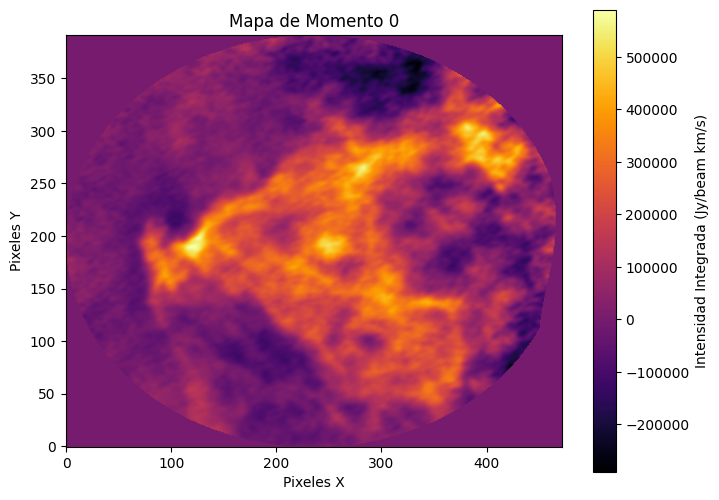

In [16]:

# Graficar el momento 0
plt.figure(figsize=(8, 6))
plt.imshow(moment0, origin='lower', cmap='inferno')
plt.colorbar(label='Intensidad Integrada (Jy/beam km/s)')
plt.title("Mapa de Momento 0")
plt.xlabel("Pixeles X")
plt.ylabel("Pixeles Y")
plt.show()


## Cálculo del momento 1

In [17]:
with fits.open(ruta_fits) as hdul:
    header_original = hdul[0].header  # Extraer la cabecera

header_original.remove('NAXIS3', ignore_missing=True, remove_all=True)
header_original.remove('CRPIX3', ignore_missing=True, remove_all=True)
header_original.remove('CDELT3', ignore_missing=True, remove_all=True)
header_original.remove('CRVAL3', ignore_missing=True, remove_all=True)
header_original.remove('CTYPE3', ignore_missing=True, remove_all=True)
header_original['BUNIT'] = 'km/s'  # Actualizar unidades en el header para el momento 1

In [18]:
#Revisando unidades del momento1

# Cargar el header del FITS original
with fits.open(ruta_fits) as hdul:
    header_original = hdul[0].header

# Ver la frecuencia de referencia del cubo
rest_freq = header_original.get('RESTFRQ', None)  # En Hz

print(f"Frecuencia de referencia: {rest_freq} Hz")

Frecuencia de referencia: 219560358000.0 Hz


El cubo tiene el eje espectral en FRECUENCIA (Hz), no en velocidad (km/s):
- CTYPE3 = 'FREQ' → El eje espectral está en frecuencia.
- CUNIT3 = 'Hz' → Confirma que CRVAL3 y CDELT3 están en Hz.
- CRVAL3 = 219428953435.0 Hz → Valor de referencia en Hz.
- CDELT3 = 610511.705719 Hz → Ancho de canal en Hz.
- RESTFRQ = 219560358000.0 Hz → Frecuencia de referencia del cubo.

Sistema de referencia de velocidad:
- SPECSYS = 'LSRK' → Indica que las velocidades deberían estar en el sistema Local Standard of Rest (LSRK).
- VELREF = 257 → Esto indica que el eje espectral podría ser convertible a velocidad radial.

velax está en Hz y bettermoments lo usó directamente en la estimación del momento 1.

Hay que convertir los valores en velocidad.

In [19]:
c = 299792.458  # km/s

# Parámetros del header
rest_freq = 219560358000.0  # RESTFRQ en Hz
freq_axis = velax  # velax está en Hz en el cubo original

# Convertir de frecuencia a velocidad en km/s
velax_kms = c * (rest_freq - freq_axis) / rest_freq

# Imprimir valores mínimos y máximos
print(f"Min Velocidad convertida (km/s): {np.min(velax_kms)}")
print(f"Max Velocidad convertida (km/s): {np.max(velax_kms)}")


Min Velocidad convertida (km/s): -137.3476004554146
Max Velocidad convertida (km/s): 179.42263299539147


In [20]:
print(f"Ejemplo de valores de velax (Hz): {velax[:10]}")


Ejemplo de valores de velax (Hz): [2.19428953e+11 2.19429564e+11 2.19430174e+11 2.19430785e+11
 2.19431395e+11 2.19432006e+11 2.19432617e+11 2.19433227e+11
 2.19433838e+11 2.19434448e+11]


In [21]:


# Calcular el momento 0 con la máscara aplicada
#moment1, err_m1 = bm.collapse_first(velax_selected, data_masked, sigma_rms)
moment1, err_m1 = bm.collapse_first(velax_kms, data_masked, sigma_rms)


In [22]:
header_original['CTYPE3'] = 'VELO'  # Indicar que el eje espectral está en velocidad
header_original['CUNIT3'] = 'km/s'  # Cambiar unidades a km/s
header_original['BUNIT'] = 'km/s'  # Unidades del Momento 1

# Guardar el nuevo FITS corregido
hdu_m1 = fits.PrimaryHDU(moment1, header=header_original)
hdu_m1.writeto('/home/jennifer/casa/M17_SW/ALMA01480118_momento1_BM.fits', overwrite=True)

print("Archivo de Momento 1 corregido y guardado con unidades en km/s.")


Archivo de Momento 1 corregido y guardado con unidades en km/s.


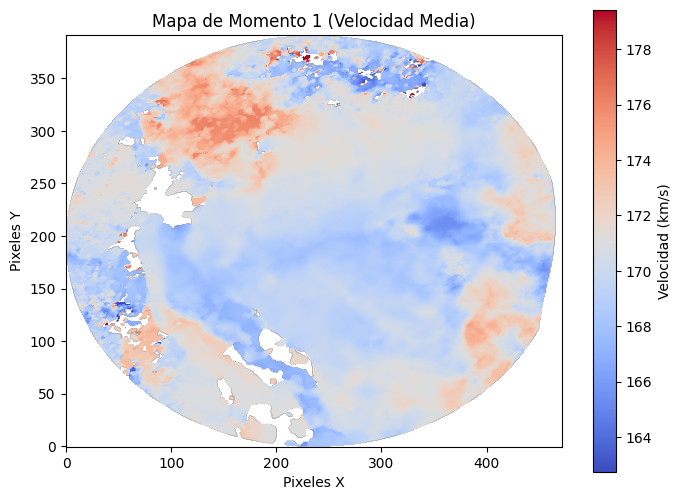

In [23]:
# Graficar el momento 1
plt.figure(figsize=(8, 6))
plt.imshow(moment1, origin='lower', cmap='coolwarm')  # 'coolwarm' resalta rojo-azul
plt.colorbar(label='Velocidad (km/s)')
plt.title("Mapa de Momento 1 (Velocidad Media)")
plt.xlabel("Pixeles X")
plt.ylabel("Pixeles Y")
plt.show()

In [51]:
# Calcular el mínimo y máximo ignorando NaNs
v1_min = np.nanmin(moment1)
v1_max = np.nanmax(moment1)

# Imprimir en pantalla
print(f"Velocidad mínima en el mapa de Momento 1: {v1_min:.2f} km/s")
print(f"Velocidad máxima en el mapa de Momento 1: {v1_max:.2f} km/s")


Velocidad mínima en el mapa de Momento 1: 299792.43 km/s
Velocidad máxima en el mapa de Momento 1: 299792.44 km/s


In [36]:
print(f"Velocidad mínima en km/s: {np.min(velax_kms)}")
print(f"Velocidad máxima en km/s: {np.max(velax_kms)}")


Velocidad mínima en km/s: 299792.4178926858
Velocidad máxima en km/s: 299792.4406571554


In [50]:
print(f"Min Momento 1 (km/s): {np.nanmin(moment1)}")
print(f"Max Momento 1 (km/s): {np.nanmax(moment1)}")


Min Momento 1 (km/s): 120369.58001705965
Max Momento 1 (km/s): 120369.60278152814


In [52]:
print(f"Valor de ALTRVAL en el header: {header_original.get('ALTRVAL', None)}")


Valor de ALTRVAL en el header: 179422.6329954
